# Flow analysis of the Oslo city bikes network

### Authors: Niclas Classen & Manuel Knepper
**Summary:** This notebook is used to analyze the flow of the Oslo City Bike network. The data for the bike rides is taken from https://oslobysykkel.no/en/open-data and the data for the city districts is taken from https://kartkatalog.dev.geonorge.no/metadata/administrative-enheter-kommuner/041f1e6e-bdbc-4091-b48f-8a5990f3cc5b.

**Reproducibility:** The repository contains the raw and preprocessed data as well as the code to reproduce the analysis. The notebook is written to run from top to bottom.

## Part 1: Data Preprocessing

#### Data Sources:
- Oslo City Bike Data: https://oslobysykkel.no/en/open-data
- Oslo Districts Geojson: https://kartkatalog.dev.geonorge.no/metadata/administrative-enheter-kommuner/041f1e6e-bdbc-4091-b48f-8a5990f3cc5b

#### Data Structure
The data is stored in the following folder structure:
- `data/`: Contains all the raw and preprocessed data
- `data/monthly`: Contains the monthly raw data for the bike rides
- `data/oslo_districts.geojson`: Contains the geojson file of the Oslo districts

As result of the data preprocessing, we have the following files:
- `data/preprocessed_bike_rides.csv`: Contains the preprocessed bike rides data of all months

In [1]:
import pandas as pd
import os
from tqdm import tqdm
from dotenv import load_dotenv

load_dotenv()

False

In [2]:
# !!! Set the path to the data directory in the .env file !!!
#_path = os.environ.get("PATH_TO_DATA_DIRECTORY")
_path = "/Users/manuel/Documents/Semester 2/Geospatial Data Science/Exam_Project_Geospatial/data"

#### Create one file for all bike rides

In [3]:
# The following runs for 2 minutes on a 2019 MacBook Pro with 16GB RAM and 1,4 GHz Quad-Core Intel Core i5

dir_path = os.path.join(_path, 'monthly')
export_path = os.path.join(_path)

# Get a list of all csv files in the directory
csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]
dataframes = []

for file in tqdm(csv_files):
    # Extract year and month from filename
    year, month = file.split('.')[0].split('_')

    # Read csv file into a dataframe
    df = pd.read_csv(os.path.join(dir_path, file))

    # Add a new column for the month and year
    df['month'] = month
    df['year'] = year

    # Check if the DataFrame is not empty or does not contain only NaN values (avoid warning when concatenating dfs)
    if not df.empty and not df.isna().all().all():
        dataframes.append(df)

# Concatenate all dataframes into a single dataframe
if dataframes:
    combined_df = pd.concat(dataframes)

    # Write the combined dataframe to a new csv file in the export directory
    combined_df.to_csv(f'{export_path}/preprocessed_bike_rides.csv', index=False)

100%|██████████| 61/61 [00:15<00:00,  3.97it/s]


In [4]:
# First look at the data
combined_df.head(3)

started_at                          ended_at  \
0  2023-10-01 00:00:40.773000+00:00  2023-10-01 00:04:34.682000+00:00   
1  2023-10-01 03:01:18.390000+00:00  2023-10-01 03:08:24.193000+00:00   
2  2023-10-01 03:06:04.201000+00:00  2023-10-01 03:09:44.839000+00:00   

   duration  start_station_id   start_station_name start_station_description  \
0       233               507    Jens Bjelkes Gate       ved Trondheimsveien   
1       425               607  Marcus Thranes gate             ved Akerselva   
2       220               500          Anker Hotel            langs Storgata   

   start_station_latitude  start_station_longitude  end_station_id  \
0               59.919147                10.764130            2339   
1               59.932772                10.758595             393   
2               59.917279                10.758155             506   

            end_station_name         end_station_description  \
0                  Elgsletta              langs Nylandsveien   
1  Hans Nielsen Hauges plass  langs Hans Nielsen Hauges gate   
2         Botanisk Hage vest                 ved Blytts gate   

   end_station_latitude  end_station_longitude month year  
0             59.915649              10.761725    10   23  
1             59.939244              10.774319    10   23  
2             59.920128              10.768875    10   23

## Part 2: Data Analysis
**Structure of our analysis:**
1. General data analysis
    - First look at the data
    - Changes of the station network over the years
    - Basic behavior of the bike rides
2. Flow analysis
    - Flow between stations
    - Flow between districts
3. Spatial autocorrelation
    - Choropleth map
    - Moran's I
    - LISA
4. Find new stations
    - Find new stations to increase network density

In [5]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString, Polygon
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler
from geopandas.tools import sjoin
from pycirclize import Circos
import osmnx as ox
from itertools import combinations
from scipy.spatial import cKDTree
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster

/Users/manuel/Documents/Semester 2/Geospatial Data Science/Exam_Project_Geospatial/venv/lib/python3.11/site-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


### Helper functions
First we define some helper functions to load the data that we need for the analysis.

In [6]:
def create_stations_gdf(df: pd.DataFrame, crs_in: int = 4326, crs_out: int = 3857) -> gpd.GeoDataFrame:
    df = df.copy()  # Create a copy to avoid changing the original DataFrame

    # Create unique dataframes for start and end stations
    start_stations = df[
        [
            "start_station_id",
            "start_station_name",
            "start_station_description",
            "start_station_latitude",
            "start_station_longitude",
            "month",
            "year",
        ]
    ].drop_duplicates()
    end_stations = df[
        [
            "end_station_id",
            "end_station_name",
            "end_station_description",
            "end_station_latitude",
            "end_station_longitude",
            "month",
            "year",
        ]
    ].drop_duplicates()

    # Rename columns for uniformity
    start_stations.columns = [
        "station_id",
        "station_name",
        "station_description",
        "latitude",
        "longitude",
        "month",
        "year",
    ]
    end_stations.columns = [
        "station_id",
        "station_name",
        "station_description",
        "latitude",
        "longitude",
        "month",
        "year",
    ]

    # Concatenate the dfs and drop duplicates
    stations = pd.concat([start_stations, end_stations]).drop_duplicates()
    
    # Create GeoDataFrame
    gdf_stations = gpd.GeoDataFrame(
        stations,
        geometry=gpd.points_from_xy(stations.longitude, stations.latitude),
        crs=crs_in,
    )
    gdf_stations = gdf_stations.to_crs(epsg=crs_out)

    return gdf_stations

def create_rides_gdf(df: pd.DataFrame, crs_in: int = 4326, crs_out: int = 3857) -> gpd.GeoDataFrame:
    df = df.copy()  # Create a copy to avoid changing the original DataFrame
    
    # Create a new DataFrame with necessary columns
    df_rides = df[
        [
            "start_station_id",
            "end_station_id",
            "started_at",
            "ended_at",
            "duration",
            "start_station_name",
            "start_station_description",
            "start_station_latitude",
            "start_station_longitude",
            "end_station_name",
            "end_station_description",
            "end_station_latitude",
            "end_station_longitude",
            "month",
            "year",
        ]
    ].copy() # copy to avoid warning

    # Create LineString objects
    df_rides.loc[:, "geometry"] = df_rides.apply(
        lambda row: LineString(
            [
                (row["start_station_longitude"], row["start_station_latitude"]),
                (row["end_station_longitude"], row["end_station_latitude"]),
            ]
        ),
        axis=1,
    )

    # Create GeoDataFrame
    gdf_rides = gpd.GeoDataFrame(df_rides, geometry="geometry", crs=crs_in)
    gdf_rides = gdf_rides.to_crs(epsg=crs_out)
    return gdf_rides

def create_oslo_districts_gdf(
    data_path: str = "data/oslo_districts.geojson",
    crs_in: int = 32633,
    crs_out: int = 3857,
) -> gpd.GeoDataFrame:
    gdf_oslo_districts = gpd.read_file(data_path)

    # Set the correct CRS
    gdf_oslo_districts.set_crs(crs_in, inplace=True, allow_override=True)

    # Reproject the data
    gdf_oslo_districts = gdf_oslo_districts.to_crs(epsg=crs_out)

    # Rename columns
    gdf_oslo_districts = gdf_oslo_districts.rename(columns={"bydelnavn": "district"})

    return gdf_oslo_districts

### 2.1 General data analysis

In [7]:
# The following runs for 5 minutes on a 2019 MacBook Pro with 16GB RAM and 1,4 GHz Quad-Core Intel Core i5

# Read the preprocessed data
df = pd.read_csv(f'{_path}/preprocessed_bike_rides.csv')

# Create GeoDataFrames for stations and rides
gdf_stations_unfiltered = create_stations_gdf(df) # don't filtered by month or year (so that we can analyse the differences in stations over time)
gdf_stations = gdf_stations_unfiltered.drop_duplicates(subset=['station_id']) # get all unique stations that ever existed
gdf_stations_last_month = create_stations_gdf(df.loc[(df['year'] == 24) & (df['month'] == 4)]) # get stations from april 2024
gdf_stations_last_year = create_stations_gdf(df.loc[((df['year'] == 23) & (df['month'] >= 5)) | ((df['year'] == 24) & (df['month'] < 5))]).drop_duplicates(subset=['station_id']) # get stations from mai 2023 to april 2024 (last year)

gdf_rides = create_rides_gdf(df)
gdf_rides_last_year = create_rides_gdf(df.loc[((df['year'] == 23) & (df['month'] >= 5)) | ((df['year'] == 24) & (df['month'] < 5))]) # rides from mai 2023 to april 2024 (last year)

# Create GeoDataFrame for Oslo districts
gdf_oslo_districts = create_oslo_districts_gdf()

#### 2.1.1 Let's have a first look at the data

##### Oslo Bike Stations

In [8]:
print("Stations gdf unfiltered shape:", gdf_stations_unfiltered.shape)
print("Stations filtered by station_id gdf shape:", gdf_stations.shape)
print("Stations filtered by station_id last month gdf shape:", gdf_stations_last_month.shape)
print("Stations filtered by station_id last year gdf shape:", gdf_stations_last_year.shape)
gdf_stations.head(3)

Stations gdf unfiltered shape: (15332, 8)
Stations filtered by station_id gdf shape: (286, 8)
Stations filtered by station_id last month gdf shape: (267, 8)
Stations filtered by station_id last year gdf shape: (273, 8)


station_id         station_name  station_description   latitude  longitude  \
0         507    Jens Bjelkes Gate  ved Trondheimsveien  59.919147  10.764130   
1         607  Marcus Thranes gate        ved Akerselva  59.932772  10.758595   
2         500          Anker Hotel       langs Storgata  59.917279  10.758155   

   month  year                         geometry  
0     10    23  POINT (1198257.424 8381758.913)  
1     10    23  POINT (1197641.308 8384785.559)  
2     10    23  POINT (1197592.370 8381344.042)

In [9]:
gdf_stations.explore()

##### Bike Rides

In [10]:
print("Rides gdf shape:", gdf_rides.shape)
print("Rides gdf of last year shape:", gdf_rides_last_year.shape)
gdf_rides.head(3)

Rides gdf shape: (7897309, 16)
Rides gdf of last year shape: (1106880, 16)


start_station_id  end_station_id                        started_at  \
0               507            2339  2023-10-01 00:00:40.773000+00:00   
1               607             393  2023-10-01 03:01:18.390000+00:00   
2               500             506  2023-10-01 03:06:04.201000+00:00   

                           ended_at  duration   start_station_name  \
0  2023-10-01 00:04:34.682000+00:00       233    Jens Bjelkes Gate   
1  2023-10-01 03:08:24.193000+00:00       425  Marcus Thranes gate   
2  2023-10-01 03:09:44.839000+00:00       220          Anker Hotel   

  start_station_description  start_station_latitude  start_station_longitude  \
0       ved Trondheimsveien               59.919147                10.764130   
1             ved Akerselva               59.932772                10.758595   
2            langs Storgata               59.917279                10.758155   

            end_station_name         end_station_description  \
0                  Elgsletta              langs Nylandsveien   
1  Hans Nielsen Hauges plass  langs Hans Nielsen Hauges gate   
2         Botanisk Hage vest                 ved Blytts gate   

   end_station_latitude  end_station_longitude  month  year  \
0             59.915649              10.761725     10    23   
1             59.939244              10.774319     10    23   
2             59.920128              10.768875     10    23   

                                            geometry  
0  LINESTRING (1198257.424 8381758.913, 1197989.6...  
1  LINESTRING (1197641.308 8384785.559, 1199391.7...  
2  LINESTRING (1197592.370 8381344.042, 1198785.7...

##### Oslo City Districts

In [11]:
print("Oslo districts gdf shape:", gdf_oslo_districts.shape)
gdf_oslo_districts.head(3)

Oslo districts gdf shape: (17, 3)


district bydelnr  \
0            Frogner  030105   
1           Østensjø  030113   
2  Søndre Nordstrand  030115   

                                            geometry  
0  MULTIPOLYGON (((1189421.693 8375826.292, 11864...  
1  MULTIPOLYGON (((1206718.020 8369118.365, 12067...  
2  MULTIPOLYGON (((1210120.108 8358267.151, 12100...

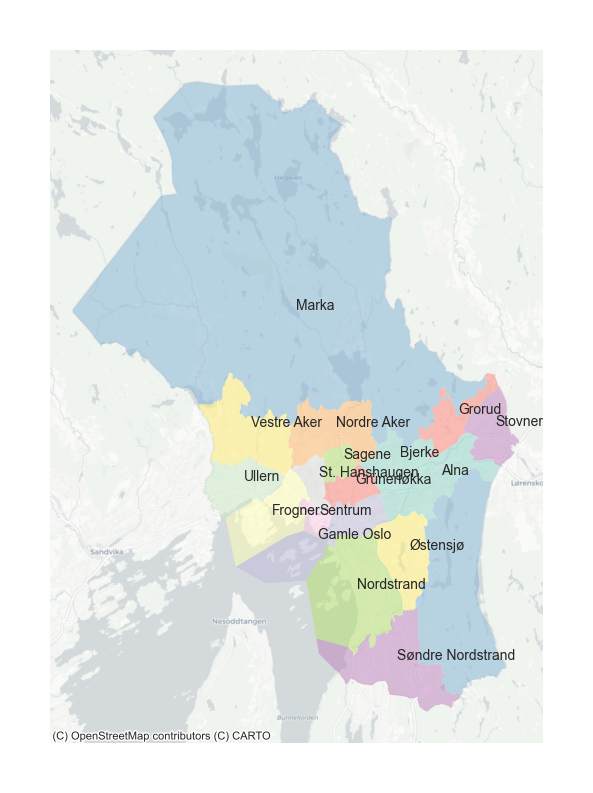

In [12]:
# Plot the different districts in Oslo
ax = gdf_oslo_districts.plot(column='district', cmap='Set3', alpha=0.5, figsize=(9, 9))

# Add a basemap
cx.add_basemap(ax, crs=gdf_oslo_districts.crs, source=cx.providers.CartoDB.Positron)

# Add the name of each district
for x, y, label in zip(gdf_oslo_districts.geometry.centroid.x, gdf_oslo_districts.geometry.centroid.y, gdf_oslo_districts['district']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

ax.set_axis_off()
ax.set_aspect('equal')

#### 2.1.2 Changes of the station network over the years

In [13]:
# Split the stations GeoDataFrame by year
gdf_stations_by_year = {}
difference_stations_by_year = {}

for year in range(19, 25):
    gdf_stations_by_year[year] = gdf_stations_unfiltered[gdf_stations_unfiltered['year'] == year].drop_duplicates(subset=['station_id'])

    if year != 19:
        difference_stations_by_year[f'{year - 1}_{year}'] = set(gdf_stations_by_year[year]['station_id'].unique()) - set(gdf_stations_by_year[year - 1]['station_id'].unique())
        difference_stations_by_year[f'{year}_{year - 1}'] = set(gdf_stations_by_year[year - 1]['station_id'].unique()) - set(gdf_stations_by_year[year]['station_id'].unique())

In [14]:
# Get number of unique stations for entire dataset and for different years
for year, df in gdf_stations_by_year.items():
    number = df['station_id'].nunique()
    print(f"Number of stations in {year}: {number}")

Number of stations in 19: 254
Number of stations in 20: 255
Number of stations in 21: 262
Number of stations in 22: 269
Number of stations in 23: 273
Number of stations in 24: 268


##### Changes from 2019 to 2024 (general overview)

In [15]:
gdf_stations_2019 = gdf_stations_by_year[19]
gdf_stations_2024 = gdf_stations_by_year[24]

stations_2019 = gdf_stations_2019['station_id'].unique()
stations_2024 = gdf_stations_2024['station_id'].unique()

# remove existing stations from 2024
difference_19_24 = set(stations_2024) - set(stations_2019)
difference_24_19 = set(stations_2019) - set(stations_2024)

stations_change_2024_2019_df = gdf_stations_2024.loc[gdf_stations_2024['station_id'].isin(list(difference_19_24))]
stations_change_2019_2024_df = gdf_stations_2019.loc[gdf_stations_2019['station_id'].isin(list(difference_24_19))]

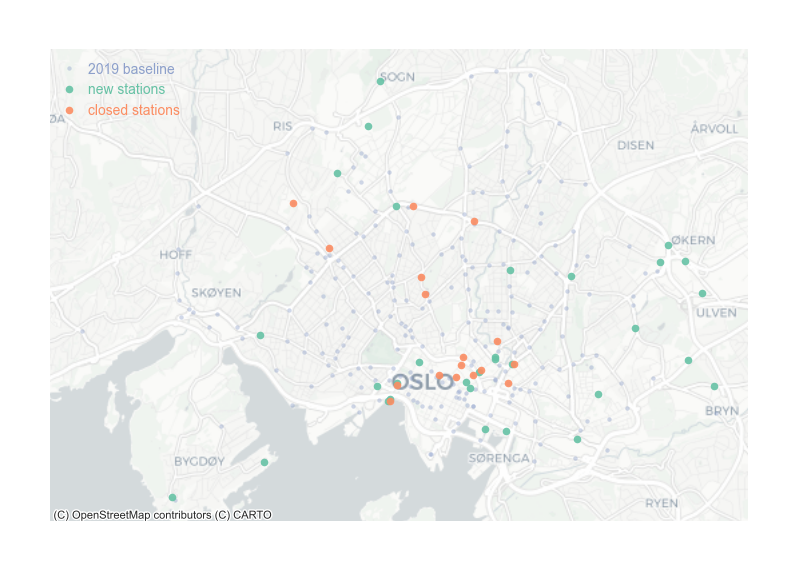

In [16]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_stations_by_year[19].plot(alpha=0.4, ax=ax, color='#8da0cb', markersize=10, label='2019 baseline')
stations_change_2024_2019_df.plot(alpha=0.9, ax=ax, color='#66c2a5', markersize=30, label='new stations')
stations_change_2019_2024_df.plot(alpha=0.9, ax=ax, color='#fc8d62', markersize=30, label='closed stations')

ax.set_axis_off()
plt.legend(labelcolor= ['#8da0cb','#66c2a5', '#fc8d62'],loc='upper left')
cx.add_basemap(ax, crs=gdf_stations_by_year[19].crs, source=cx.providers.CartoDB.Positron)

plt.savefig(f'figures/stations_change_2019_2024.png', bbox_inches='tight', pad_inches=0)
plt.show()

##### Yearly changes

In [17]:
# We already have the data for 2019 and 2024, but the other years are missing
gdf_stations_2020 = gdf_stations_by_year[20]
gdf_stations_2021 = gdf_stations_by_year[21]
gdf_stations_2022 = gdf_stations_by_year[22]
gdf_stations_2023 = gdf_stations_by_year[23]

stations_2020 = gdf_stations_2020['station_id'].unique()
stations_2021 = gdf_stations_2021['station_id'].unique()
stations_2022 = gdf_stations_2022['station_id'].unique()
stations_2023 = gdf_stations_2023['station_id'].unique()

# get differences between the years
difference_19_20 = set(stations_2020) - set(stations_2019)
difference_20_19 = set(stations_2019) - set(stations_2020)

difference_20_21 = set(stations_2021) - set(stations_2020)
difference_21_20 = set(stations_2020) - set(stations_2021)

difference_21_22 = set(stations_2022) - set(stations_2021)
difference_22_21 = set(stations_2021) - set(stations_2022)

difference_22_23 = set(stations_2023) - set(stations_2022)
difference_23_22 = set(stations_2022) - set(stations_2023)

difference_23_24 = set(stations_2024) - set(stations_2023)
difference_24_23 = set(stations_2023) - set(stations_2024)

# Datasets with changes in stations from year to year
stations_change_2019_2020_df = gdf_stations_2020.loc[gdf_stations_2020['station_id'].isin(list(difference_19_20))]
stations_change_2020_2019_df = gdf_stations_2019.loc[gdf_stations_2019['station_id'].isin(list(difference_20_19))]

stations_change_2020_2021_df = gdf_stations_2021.loc[gdf_stations_2021['station_id'].isin(list(difference_20_21))]
stations_change_2021_2020_df = gdf_stations_2020.loc[gdf_stations_2020['station_id'].isin(list(difference_21_20))]

stations_change_2021_2022_df = gdf_stations_2022.loc[gdf_stations_2022['station_id'].isin(list(difference_21_22))]
stations_change_2022_2021_df = gdf_stations_2021.loc[gdf_stations_2021['station_id'].isin(list(difference_22_21))]

stations_change_2022_2023_df = gdf_stations_2023.loc[gdf_stations_2023['station_id'].isin(list(difference_22_23))]
stations_change_2023_2022_df = gdf_stations_2022.loc[gdf_stations_2022['station_id'].isin(list(difference_23_22))]

stations_change_2023_2024_df = gdf_stations_2024.loc[gdf_stations_2024['station_id'].isin(list(difference_23_24))]
stations_change_2024_2023_df = gdf_stations_2023.loc[gdf_stations_2023['station_id'].isin(list(difference_24_23))]

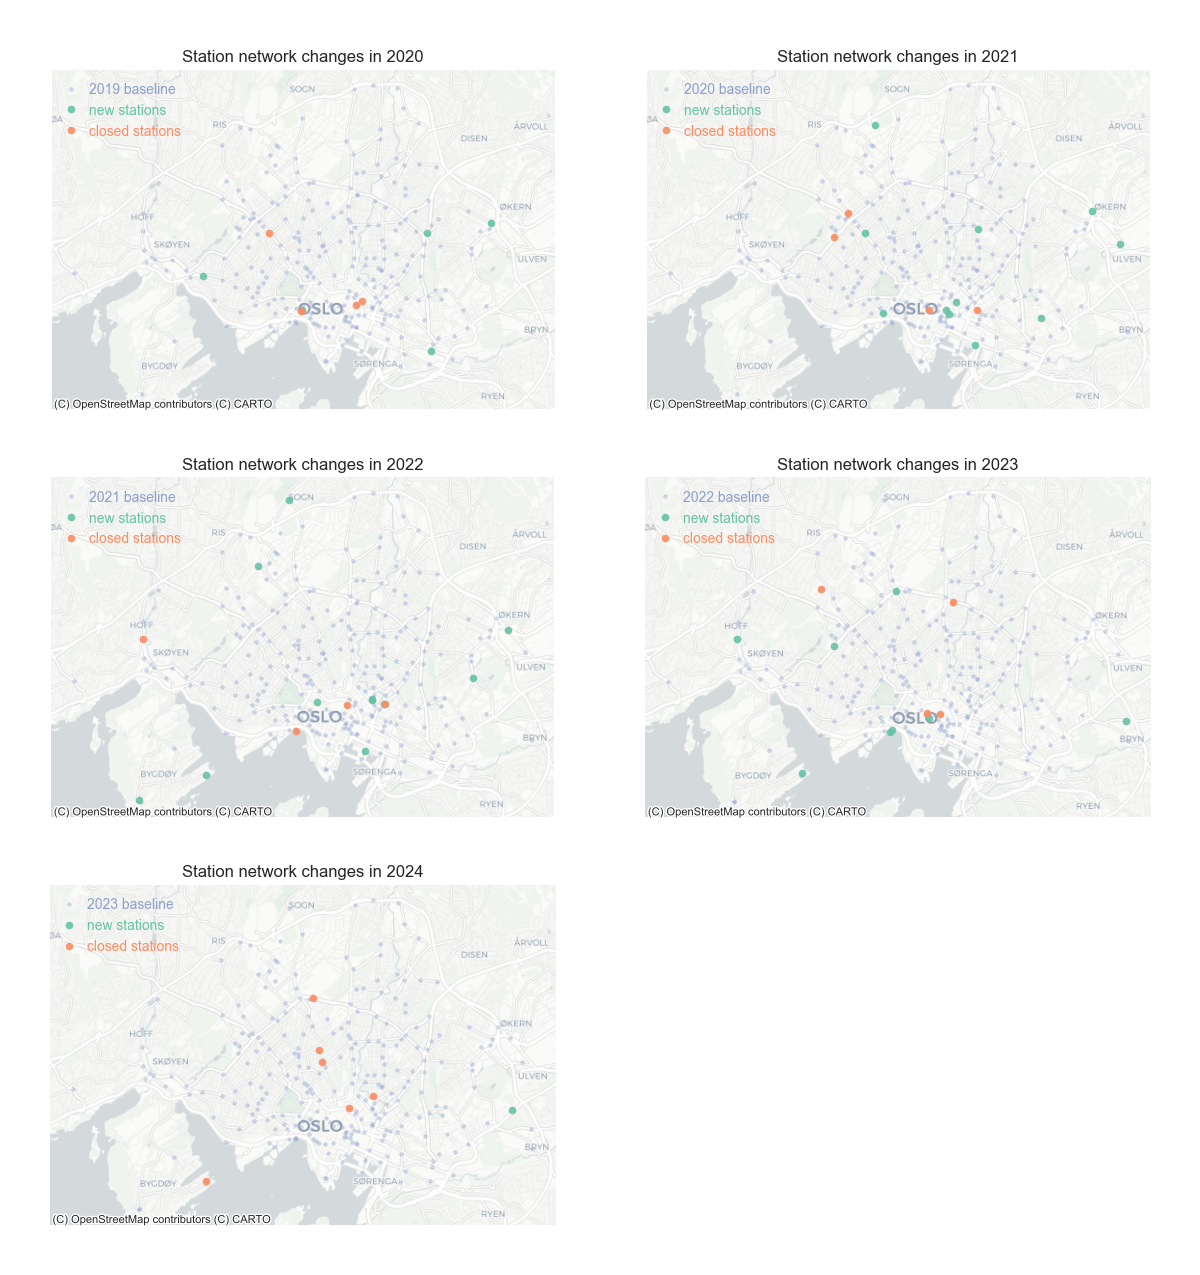

In [18]:
# list of dfs with new stations
df_new_list = [stations_change_2019_2020_df, stations_change_2020_2021_df, 
               stations_change_2021_2022_df, stations_change_2022_2023_df, 
               stations_change_2023_2024_df]

# list of dfs with old stations
df_closed_list = [stations_change_2020_2019_df, stations_change_2021_2020_df, 
                  stations_change_2022_2021_df, stations_change_2023_2022_df, 
                  stations_change_2024_2023_df]

years = list(range(20, 25))

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs = axs.flatten()

for i, (df_new, df_closed) in enumerate(zip(df_new_list, df_closed_list)):
    gdf_stations_by_year[years[i]-1].plot(alpha=0.4, ax=axs[i], color='#8da0cb', markersize=10, label=f'20{years[i]-1} baseline')
    df_new.plot(alpha=0.9, ax=axs[i], color='#66c2a5', markersize=30, label='new stations')
    df_closed.plot(alpha=0.9, ax=axs[i], color='#fc8d62', markersize=30, label='closed stations')

    axs[i].set_axis_off()
    axs[i].set_title(f'Station network changes in 20{years[i]}')

    axs[i].legend(labelcolor= ['#8da0cb','#66c2a5', '#fc8d62'],loc='upper left')
    cx.add_basemap(axs[i], crs=gdf_stations_by_year[years[i]-1].crs, source=cx.providers.CartoDB.Positron)

plt.subplots_adjust(wspace=0.05)

# Remove the last empty subplot
fig.delaxes(axs[-1])


plt.savefig(f'figures/stations_change_all_years.png', bbox_inches='tight', pad_inches=0)
plt.show()

#### 2.1.3 Basic behavior of the bike rides

##### Distribution of rental durations

In [19]:
# function to format y-tick labels
def thousands(x, pos):
    return '%1.0fK' % (x * 0.001)

In [20]:
def plot_histogram_of_trip_durations(gdf_rides_input, plot_title):
    
    formatter = FuncFormatter(thousands)

    # Format durations to minutes and cap them at 100 minutes
    gdf_rides_input['duration_in_minutes'] = gdf_rides_input['duration'] / 60
    gdf_rides_input['duration_capped'] = np.where(gdf_rides_input['duration_in_minutes'] > 100, 100, gdf_rides_input['duration_in_minutes'])

    # Calculate 75th percentile
    percentiles = np.percentile(gdf_rides_input['duration_capped'], [75])

    sns.set_color_codes('pastel')

    # Create a histogram of the capped durations
    sns.histplot(gdf_rides_input['duration_capped'], bins=50, color='b', edgecolor="none")

    # Add vertical lines for the percentiles
    for percentile in percentiles:
        plt.axvline(x=percentile, color='r', linestyle='--')
        plt.text(percentile+1, plt.gca().get_ylim()[1], '75th percentile', color='r', rotation=90, verticalalignment='top')

    # Set the title and labels of the plot
    plt.title(plot_title, fontsize=13)
    plt.xlabel('Duration (minutes)', fontsize=12)
    plt.ylabel('Number of trips', fontsize=12)

    # Set x-axis labels to increments of 5
    plt.xticks(np.arange(0, max(gdf_rides_input['duration_capped'])+5, 5))

    # Format y-axis labels to thousands
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.savefig(f'figures/histogram_trip_durations.png', bbox_inches='tight', pad_inches=0)
    plt.show()

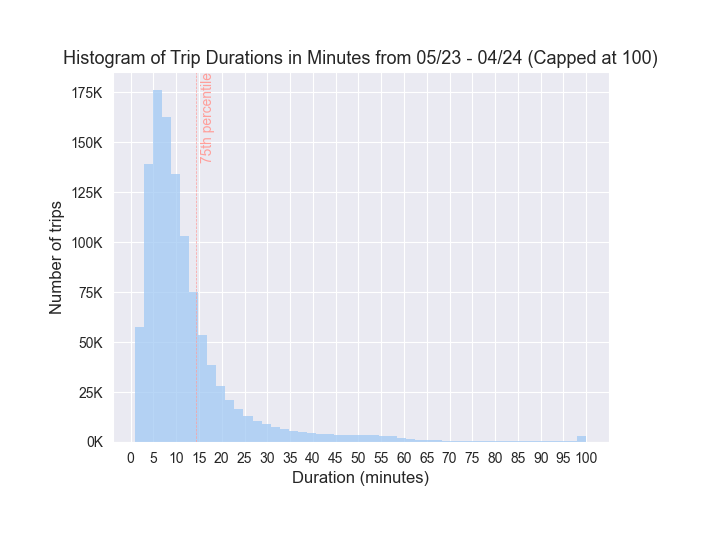

In [21]:
plot_title = 'Histogram of Trip Durations in Minutes from 05/23 - 04/24 (Capped at 100)'
plot_histogram_of_trip_durations(gdf_rides_last_year, plot_title)

##### Number of rides per day

In [22]:
# this is a small helper function to parse the dates
def custom_date_parser(d):
    return parse(d)

In [23]:
def plot_number_of_rides_per_day(gdf_rides_input, plot_title):
    tqdm.pandas()

    # Convert 'started_at' to datetime format
    gdf_rides_input['started_at_converted'] = gdf_rides_input['started_at'].progress_apply(custom_date_parser)

    # Extract the hour and day of the week
    gdf_rides_input['day'] = gdf_rides_input['started_at_converted'].dt.day
    gdf_rides_input['hour'] = gdf_rides_input['started_at_converted'].dt.hour
    gdf_rides_input['day_of_week'] = gdf_rides_input['started_at_converted'].dt.dayofweek
    gdf_rides_input['weekday_or_weekend'] = gdf_rides_input['day_of_week'].progress_apply(lambda x: 'Weekday' if x < 5 else 'Weekend')

    bins = list(range(0, 25, 1))  # Create bins for each hour
    labels = [f'{i}-{i+1}' for i in bins[:-1]]  # Create labels for each bin
    gdf_rides_input['hour_interval'] = pd.cut(gdf_rides_input['hour'], bins=bins, labels=labels, right=False)

    # Group by 'day', 'hour_interval', and 'weekday_or_weekend' and count the number of trips
    grouped = gdf_rides_input.groupby(['day_of_week', 'hour_interval', 'weekday_or_weekend'], observed=True).size().reset_index(name='num_trips')

    plt.figure(figsize=(15, 8))
    plt.title(plot_title, fontsize=13)
    plt.xlabel('Hour of the Day', fontsize=12)
    plt.ylabel('Number of Trips', fontsize=12)
    
    sns.lineplot(data=grouped, x='hour_interval', y='num_trips', hue='weekday_or_weekend')
    plt.legend(title='')

    plt.savefig(f'figures/number_of_rides_per_day.png', bbox_inches='tight', pad_inches=0)
    plt.show()

100%|██████████| 1106880/1106880 [00:00<00:00, 3112423.98it/s]


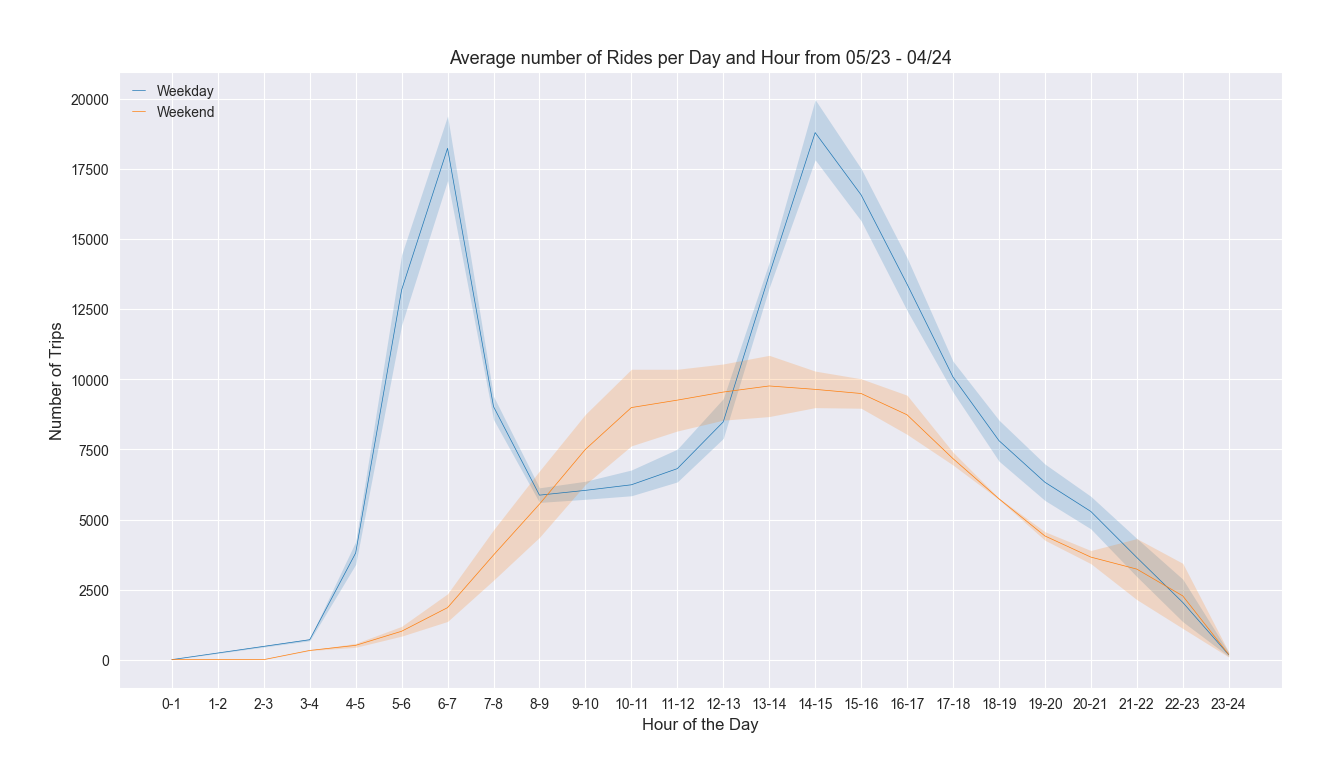

In [24]:
# The following runs for 15 minutes on a 2019 MacBook Pro with 16GB RAM and 1,4 GHz Quad-Core Intel Core i5 for all the rides and 2 mins for the last year
plot_title = 'Average number of Rides per Day and Hour from 05/23 - 04/24'
plot_number_of_rides_per_day(gdf_rides_last_year, plot_title)

In [25]:
# Number of rides per hour interval
number_of_trips_weekend_weekday = gdf_rides_last_year.groupby(['hour_interval', 'weekday_or_weekend'], observed=True).size().reset_index(name='num_trips')

# Let's print the actual number of trips
print('Number of trips on weekdays:')
print(number_of_trips_weekend_weekday.loc[number_of_trips_weekend_weekday['weekday_or_weekend'] == 'Weekday'])
print('-----------------------------------')
print('Number of trips on weekends:')
print(number_of_trips_weekend_weekday.loc[number_of_trips_weekend_weekday['weekday_or_weekend'] == 'Weekend'])

Number of trips on weekdays:
   hour_interval weekday_or_weekend  num_trips
0            0-1            Weekday          3
4            3-4            Weekday       3560
6            4-5            Weekday      19027
8            5-6            Weekday      65954
10           6-7            Weekday      91220
12           7-8            Weekday      45143
14           8-9            Weekday      29348
16          9-10            Weekday      30201
18         10-11            Weekday      31194
20         11-12            Weekday      34075
22         12-13            Weekday      42413
24         13-14            Weekday      68651
26         14-15            Weekday      94021
28         15-16            Weekday      82910
30         16-17            Weekday      66990
32         17-18            Weekday      50420
34         18-19            Weekday      39073
36         19-20            Weekday      31652
38         20-21            Weekday      26439
40         21-22            Wee

##### Average trip duration per day

In [26]:
def plot_avg_trip_duration_per_day(gdf_rides_input, plot_title):
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_mapping = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    gdf_rides_input['day_of_week_name'] = gdf_rides_input['day_of_week'].map(day_mapping)
    
    average_duration = gdf_rides_input.groupby('day_of_week_name')['duration_in_minutes'].mean()
    average_duration = average_duration.reindex(weekdays)
    
    print(f'{plot_title}: ')
    print(average_duration)

    sns.set_color_codes('pastel')
    sns.barplot(x=average_duration.values, y=average_duration.index, color='b', orient='h')

    # Set the title and labels of the plot
    plt.title(plot_title, fontsize=13)
    plt.xlabel('Average trip duration (minutes)', fontsize=12)
    plt.ylabel('Day of the Week', fontsize=12)

    plt.savefig(f'figures/avg_trip_duration_per_day.png', bbox_inches='tight', pad_inches=0)
    plt.show()


Average Trip Duration per Day of the Week from 05/23 - 04/24: 
day_of_week_name
Monday       12.003564
Tuesday      11.635371
Wednesday    11.745624
Thursday     12.060669
Friday       12.337010
Saturday     14.679039
Sunday       15.518452
Name: duration_in_minutes, dtype: float64


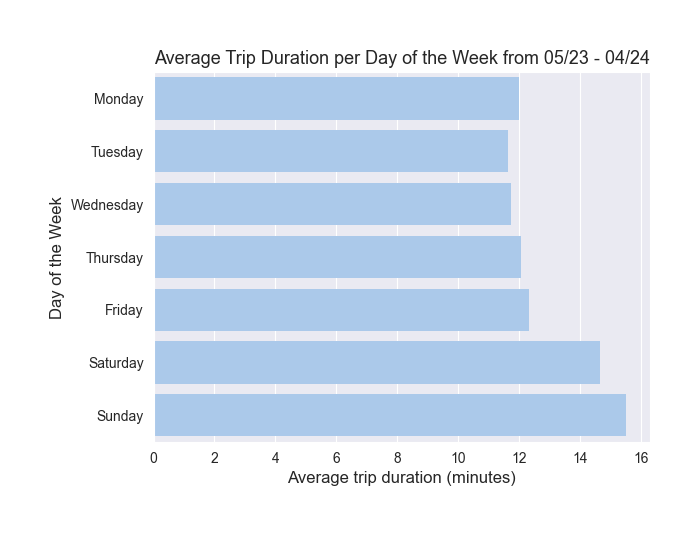

In [27]:
plot_avg_trip_duration_per_day(gdf_rides_last_year, 'Average Trip Duration per Day of the Week from 05/23 - 04/24')

### 2.2 Flow analysis

#### 2.2.1 Flow between stations

In [28]:
def get_unique_rides_count(gdf_rides_input):
    gdf_rides_unique = gdf_rides_input.drop_duplicates(subset=['start_station_id','end_station_id']).copy()
    gdf_rides_unique['count'] = gdf_rides_input.groupby(['start_station_id','end_station_id'])['start_station_id'].transform('count')

    return gdf_rides_unique

In [29]:
# get all start and end station combinations and the count
gdf_rides_unique = get_unique_rides_count(gdf_rides_last_year)
print(gdf_rides_unique.shape)
gdf_rides_unique.head(3)

(60994, 26)


start_station_id  end_station_id                        started_at  \
0               507            2339  2023-10-01 00:00:40.773000+00:00   
1               607             393  2023-10-01 03:01:18.390000+00:00   
2               500             506  2023-10-01 03:06:04.201000+00:00   

                           ended_at  duration   start_station_name  \
0  2023-10-01 00:04:34.682000+00:00       233    Jens Bjelkes Gate   
1  2023-10-01 03:08:24.193000+00:00       425  Marcus Thranes gate   
2  2023-10-01 03:09:44.839000+00:00       220          Anker Hotel   

  start_station_description  start_station_latitude  start_station_longitude  \
0       ved Trondheimsveien               59.919147                10.764130   
1             ved Akerselva               59.932772                10.758595   
2            langs Storgata               59.917279                10.758155   

            end_station_name  ... duration_in_minutes  duration_capped  \
0                  Elgsletta  ...            3.883333         3.883333   
1  Hans Nielsen Hauges plass  ...            7.083333         7.083333   
2         Botanisk Hage vest  ...            3.666667         3.666667   

              started_at_converted  day  hour day_of_week  weekday_or_weekend  \
0 2023-10-01 00:00:40.773000+00:00    1     0           6             Weekend   
1 2023-10-01 03:01:18.390000+00:00    1     3           6             Weekend   
2 2023-10-01 03:06:04.201000+00:00    1     3           6             Weekend   

   hour_interval day_of_week_name  count  
0            0-1           Sunday     64  
1            3-4           Sunday     17  
2            3-4           Sunday     40  

[3 rows x 26 columns]

In [30]:
# scale the count column
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(np.array(list(gdf_rides_unique['count'])).reshape(-1, 1))
gdf_rides_unique_scaled = gdf_rides_unique.copy()
gdf_rides_unique_scaled['count'] = np.clip(min_max_scaler.transform(np.array(list(gdf_rides_unique['count'])).reshape(-1, 1)), 0, 1)

# make sure the max value is 1 and the min value is 0
print("max", gdf_rides_unique_scaled['count'].max())
print("min", gdf_rides_unique_scaled['count'].min())

max 1.0
min 0.0


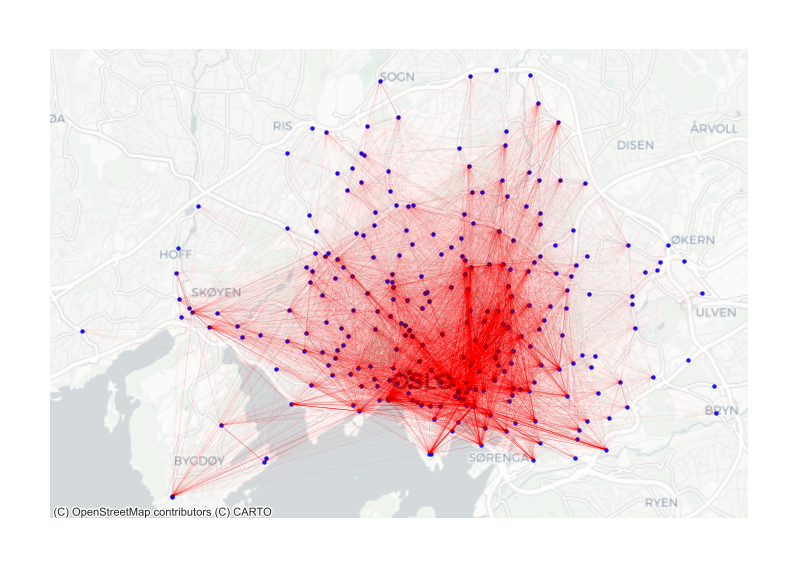

In [31]:
# plot the flow between stations scaled on transparency by the number of rides
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_rides_unique_scaled.plot(linewidth= 0.3, alpha=gdf_rides_unique_scaled['count'], ax=ax, color='red')
gdf_stations_last_year.plot(alpha=0.9, markersize=10, ax=ax, color='blue')
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf_stations_last_year.crs, source=cx.providers.CartoDB.Positron)
plt.savefig(f'figures/flow_between_stations.png', bbox_inches='tight', pad_inches=0)

##### Flow of new stations

In [32]:
stations_2019 = gdf_stations_2019['station_id'].unique()

# filter rides from or to new stations
rides_new_stations_start = gdf_rides.loc[gdf_rides['start_station_id'].isin(list(difference_19_24)) & gdf_rides['end_station_id'].isin(list(stations_2019))]
rides_new_stations_end = gdf_rides.loc[gdf_rides['end_station_id'].isin(list(difference_19_24)) & gdf_rides['start_station_id'].isin(list(stations_2019))]

# combine dataframes
frames = [rides_new_stations_start, rides_new_stations_end]
rides_new_stations = pd.concat(frames)

In [33]:
# Preprocessing
gdf_rides_unique_19_24 = rides_new_stations.drop_duplicates(subset=['start_station_id','end_station_id'])
rides_count_19_24 = rides_new_stations.groupby(['start_station_id', 'end_station_id'])['start_station_latitude'].count()

station_ids_per_ride = pd.DataFrame(data=rides_count_19_24.index, columns=['station_ids'])
rides_count_per_stations = pd.DataFrame(data=rides_count_19_24.values, columns=['count'])

rides_count_19_24_df = pd.merge(station_ids_per_ride, rides_count_per_stations, left_index=True, right_index=True)
rides_count_19_24_df[['start_station_id','end_station_id']] = rides_count_19_24_df.station_ids.apply( 
   lambda x: pd.Series(str(x).split(","))) 
rides_count_19_24_df['start_station_id'] = rides_count_19_24_df['start_station_id'].str[1:]
rides_count_19_24_df['end_station_id'] = rides_count_19_24_df['end_station_id'].str.rstrip(')')
rides_count_19_24_df['start_station_id'] = pd.to_numeric(rides_count_19_24_df['start_station_id'])
rides_count_19_24_df['end_station_id'] = pd.to_numeric(rides_count_19_24_df['end_station_id'])
gdf_rides_unique_count_19_24 = pd.merge(gdf_rides_unique_19_24, rides_count_19_24_df, 'inner',on=['start_station_id', 'end_station_id'])

In [34]:
# scale by number of rides between stations
min_max_scaler_19_24 = MinMaxScaler()
min_max_scaler_19_24.fit(np.array(list(gdf_rides_unique_count_19_24['count'])).reshape(-1, 1))
gdf_rides_unique_count_19_24_scaled = gdf_rides_unique_count_19_24.copy()
gdf_rides_unique_count_19_24_scaled['count'] = min_max_scaler_19_24.transform(np.array(list(gdf_rides_unique_count_19_24['count'])).reshape(-1, 1))

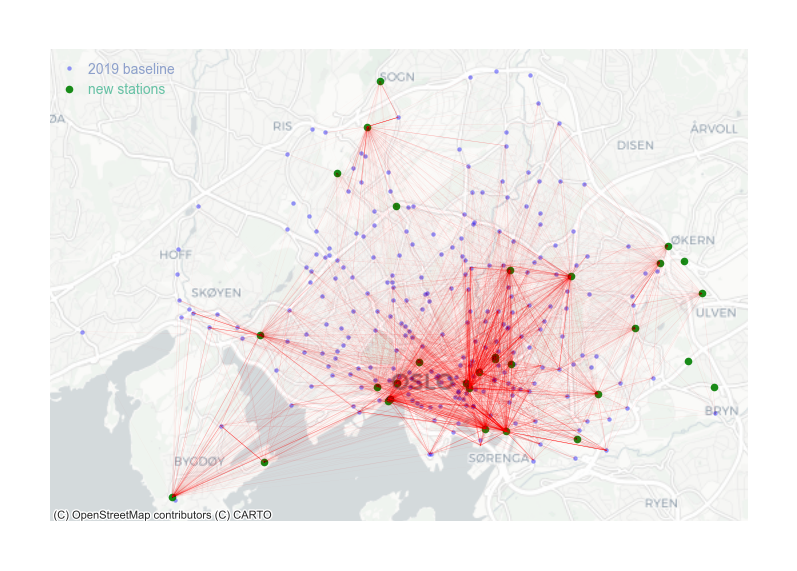

In [35]:
# plot the flow of new stations
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_rides_unique_count_19_24_scaled.plot(linewidth= 0.3, alpha=gdf_rides_unique_count_19_24_scaled['count'], ax=ax, color='red')
gdf_stations_2019.plot(alpha=0.4, markersize=10, ax=ax, color='blue', label='2019 baseline')
stations_change_2024_2019_df.plot(alpha=0.9, markersize=30, ax=ax, color='green', label='new stations')
ax.set_axis_off()

plt.legend(labelcolor= ['#8da0cb','#66c2a5'],loc='upper left')
cx.add_basemap(ax, crs=gdf_stations_2024.crs, source=cx.providers.CartoDB.Positron)
plt.savefig(f'figures/flow_between_new_stations_19_24.png', bbox_inches='tight', pad_inches=0)

##### Flow between districts

In [36]:
# Perform a spatial join between the stations and the districts
joined = sjoin(gdf_stations_last_year, gdf_oslo_districts, how='left', predicate='within')

# The 'district' column in 'joined' now contains the district of each station
gdf_stations_last_year['district'] = joined['district'] 
gdf_stations_last_year.head(5)

station_id         station_name  station_description   latitude  longitude  \
0         507    Jens Bjelkes Gate  ved Trondheimsveien  59.919147  10.764130   
1         607  Marcus Thranes gate        ved Akerselva  59.932772  10.758595   
2         500          Anker Hotel       langs Storgata  59.917279  10.758155   
3         599            Paléhaven     langs Strandgata  59.910331  10.750110   
4         597          Fredensborg    ved rundkjøringen  59.920995  10.750358   

   month  year                         geometry        district  
0     10    23  POINT (1198257.424 8381758.913)     Grünerløkka  
1     10    23  POINT (1197641.308 8384785.559)          Sagene  
2     10    23  POINT (1197592.370 8381344.042)     Grünerløkka  
3     10    23  POINT (1196696.771 8379801.076)         Sentrum  
4     10    23  POINT (1196724.378 8382169.263)  St. Hanshaugen

In [37]:
# map rides to districts
district_dict = gdf_stations_last_year.set_index('station_id')['district'].to_dict()

gdf_rides_last_year['start_district'] = gdf_rides_last_year['start_station_id'].map(district_dict)
gdf_rides_last_year['end_district'] = gdf_rides_last_year['end_station_id'].map(district_dict)

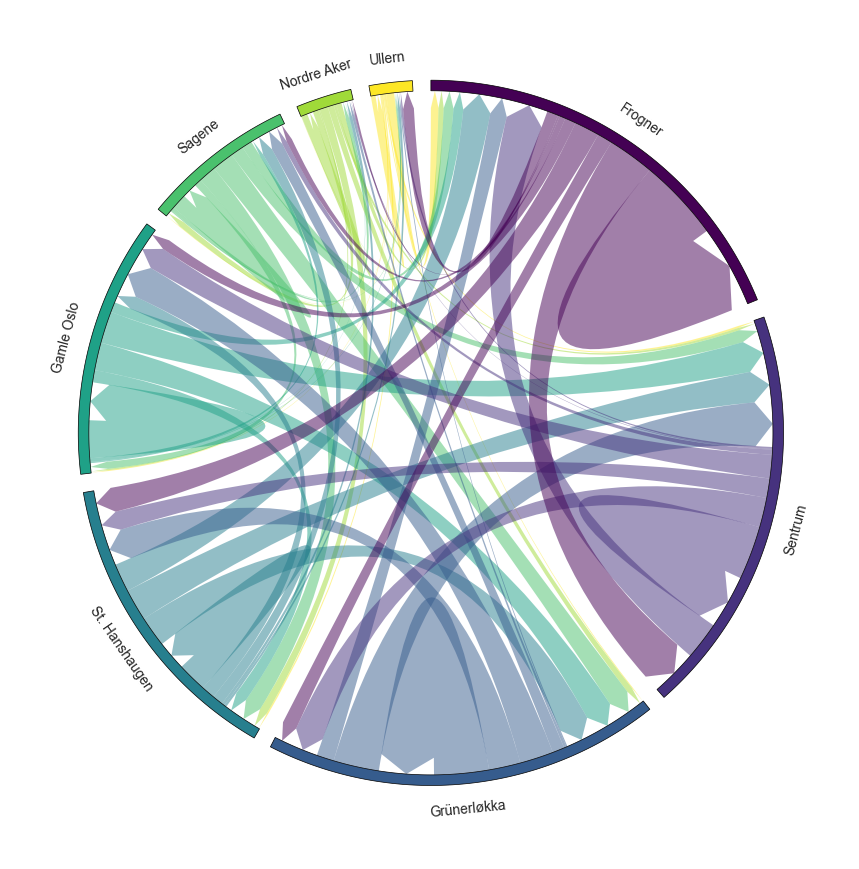

In [38]:
# create circos plot to visualize the flow between stations
districts = pd.concat([gdf_rides_last_year['start_district'], gdf_rides_last_year['end_district']])

top_districts = districts.value_counts().head(8) # limit it to top 8. Otherwise not readable
filtered_gdf_rides = gdf_rides_last_year[gdf_rides_last_year['start_district'].isin(top_districts.index) & gdf_rides_last_year['end_district'].isin(top_districts.index)]

# Create from-to table dataframe & convert to matrix
from_to_table = filtered_gdf_rides.groupby(['start_district', 'end_district']).size().unstack().fillna(0)
matrix_df = pd.DataFrame(from_to_table, index=top_districts.index, columns=top_districts.index)

circos = Circos.initialize_from_matrix(
    matrix_df,
    space=3,
    label_kws=dict(size=10, r=105),
    link_kws=dict(direction=1, ec="black", lw=0),
)
fig = circos.plotfig()
plt.savefig(f'figures/circos_plot.png', bbox_inches='tight', pad_inches=0)

### 2.3 Spatial autocorrelation

#### Choropleth map to get a first impression

In [39]:
# remove all rides where start_station_id or end_station_id is not in gdf_stations_by_year[24]
gdf_stations_cluster = gdf_stations_by_year[24] # get stations from 2024

gdf_rides_with_valid_stations = gdf_rides_last_year.loc[gdf_rides_last_year['start_station_id'].isin(gdf_stations_cluster['station_id']) & gdf_rides_last_year['end_station_id'].isin(gdf_stations_cluster['station_id'])]
gdf_rides_with_valid_stations.shape

(1083570, 27)

In [40]:
# spatial join between the stations and the districts
joined = sjoin(gdf_stations_cluster, gdf_oslo_districts, how='left', predicate='within')

# if you run the cell multiple times, you will get an error with "district" and that's why we switch to "district_right" then
try:
    gdf_stations_cluster['district'] = joined['district']
except:
    gdf_stations_cluster['district'] = joined['district_right']
    

gdf_stations_cluster.head(3)

station_id station_name station_description   latitude  longitude  \
6360154         403    Parkveien   ved trikkestoppet  59.921768  10.730476   
6360155         464  Sukkerbiten       ved gangbroen  59.905124  10.753764   
6360156         426   Gimle Kino   ved Frogner Kirke  59.917281  10.708376   

         month  year                         geometry district  
6360154      4    24  POINT (1194511.124 8382340.955)  Frogner  
6360155      4    24  POINT (1197103.483 8378645.102)  Sentrum  
6360156      4    24  POINT (1192050.941 8381344.349)  Frogner

In [41]:
# Group gdf_rides by 'start_station_id' and count the number of rides
rides_start = gdf_rides_with_valid_stations.groupby('start_station_id').size().reset_index(name='num_rides_start')
gdf_stations_cluster = gdf_stations_cluster.merge(rides_start, left_on='station_id', right_on='start_station_id', how='left')

# Group gdf_rides by 'end_station_id' and count the number of rides
rides_end = gdf_rides_with_valid_stations.groupby('end_station_id').size().reset_index(name='num_rides_end')
gdf_stations_cluster = gdf_stations_cluster.merge(rides_end, left_on='station_id', right_on='end_station_id', how='left')
gdf_stations_cluster

station_id        station_name              station_description  \
0           403           Parkveien                ved trikkestoppet   
1           464         Sukkerbiten                    ved gangbroen   
2           426          Gimle Kino                ved Frogner Kirke   
3           394   Bjølsen Studentby                ved rundkjøringen   
4           521  Jess Carlsens gate               ved Hausmanns gate   
..          ...                 ...                              ...   
263         545         Arkaden Sør           langs Dronningens gate   
264         551     Olaf Ryes plass             langs Sofienberggata   
265         576    Dronningens gate               sør for Karl Johan   
266         508   Majorstuen T-bane  ved passasje mot Sørkedalsveien   
267         549        Linaaes gate                 langs Møllergata   

      latitude  longitude  month  year                         geometry  \
0    59.921768  10.730476      4    24  POINT (1194511.124 8382340.955)   
1    59.905124  10.753764      4    24  POINT (1197103.483 8378645.102)   
2    59.917281  10.708376      4    24  POINT (1192050.941 8381344.349)   
3    59.943778  10.760121      4    24  POINT (1197811.205 8387231.202)   
4    59.918636  10.752394      4    24  POINT (1196951.014 8381645.305)   
..         ...        ...    ...   ...                              ...   
263  59.911969  10.747858      4    24  POINT (1196446.113 8380164.804)   
264  59.922425  10.758182      4    24  POINT (1197595.342 8382486.885)   
265  59.911392  10.747282      4    24  POINT (1196381.941 8380036.728)   
266  59.929857  10.714566      2    24  POINT (1192740.058 8384137.907)   
267  59.913824  10.745704      1    24  POINT (1196206.351 8380576.678)   

           district  start_station_id  num_rides_start  end_station_id  \
0           Frogner               403             4418             403   
1           Sentrum               464            12650             464   
2           Frogner               426             5564             426   
3            Sagene               394             5308             394   
4    St. Hanshaugen               521             8130             521   
..              ...               ...              ...             ...   
263         Sentrum               545             1161             545   
264     Grünerløkka               551            12693             551   
265         Sentrum               576             1693             576   
266         Frogner               508             1487             508   
267  St. Hanshaugen               549             6013             549   

     num_rides_end  
0             4397  
1            14809  
2             3401  
3             3039  
4             8111  
..             ...  
263           3445  
264          14125  
265           1822  
266           1255  
267           6636  

[268 rows x 13 columns]

In [42]:
#  group and sum number of start and end rides
district_rides_start = gdf_stations_cluster.groupby('district')['num_rides_start'].sum().reset_index(name='num_rides_start')
district_rides_end = gdf_stations_cluster.groupby('district')['num_rides_end'].sum().reset_index(name='num_rides_end')

# merge
gdf_oslo_districts = gdf_oslo_districts.merge(district_rides_start, on='district', how='left')
gdf_oslo_districts = gdf_oslo_districts.merge(district_rides_end, on='district', how='left')
gdf_oslo_districts.shape

(17, 5)

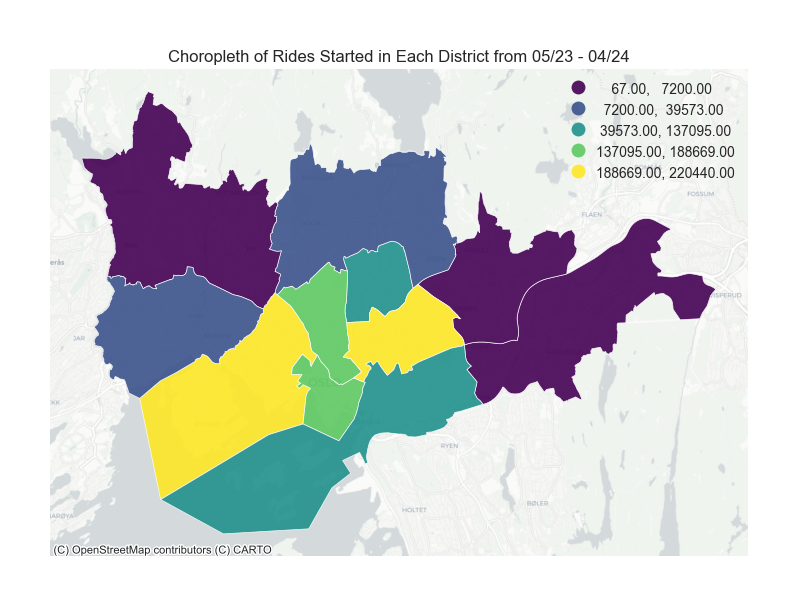

In [43]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_oslo_districts.plot(
    column="num_rides_start",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.5,
    alpha=0.9,
    legend=True,
    legend_kwds={"loc": 1},
    ax=ax,
)

plt.title("Choropleth of Rides Started in Each District from 05/23 - 04/24")
ax.set_axis_off()

cx.add_basemap(
    ax,
    crs=gdf_oslo_districts.crs,
    source=cx.providers.CartoDB.Positron
)
plt.savefig(f'figures/choropleth_rides_started.png', bbox_inches='tight', pad_inches=0)

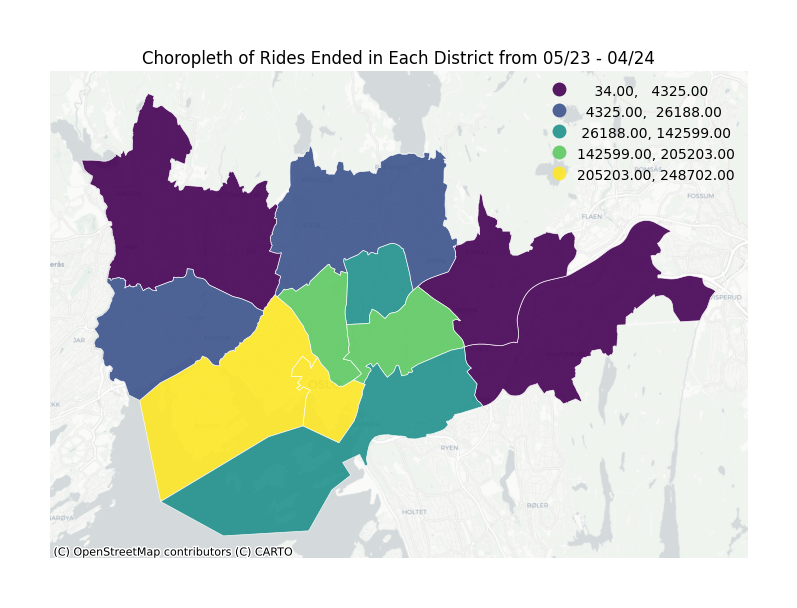

In [84]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_oslo_districts.plot(
    column="num_rides_end",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.5,
    alpha=0.9,
    legend=True,
    legend_kwds={"loc": 1},
    ax=ax,
)

plt.title("Choropleth of Rides Ended in Each District from 05/23 - 04/24")
ax.set_axis_off()

cx.add_basemap(
    ax,
    crs=gdf_oslo_districts.crs,
    source=cx.providers.CartoDB.Positron
)
plt.savefig(f'figures/choropleth_rides_ended.png', bbox_inches='tight', pad_inches=0)

### Morans I

In [44]:
def calculate_maximum_distance_closest_stations(gdf_stations_input):
    distances = gdf_stations_input.geometry.apply(lambda x: gdf_stations_input.distance(x))

    # For each station, find the minimum distance that is not zero
    min_distances = distances.apply(lambda x: np.min(x[x > 0]))

    # Calculate the maximum of these minimum distances
    maximum_distance = min_distances.max()

    return maximum_distance

In [45]:
maximum_distance = calculate_maximum_distance_closest_stations(gdf_stations_cluster) 
# convert to km
maximum_distance_km = maximum_distance / 1000
print(maximum_distance)

2873.2799340722363


Moran's I: 0.26709090001534347, p-value: 0.001


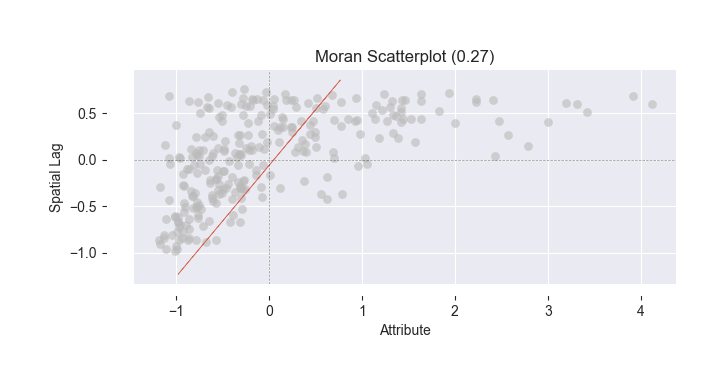

In [46]:
# calculate Morans I

# weights of the stations
w = weights.DistanceBand.from_dataframe(gdf_stations_cluster, threshold=maximum_distance, binary=True)

moran = esda.Moran(gdf_stations_cluster['num_rides_end'], w)

print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")

# Create a Moran's plot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

### LISA

##### LISA by end station

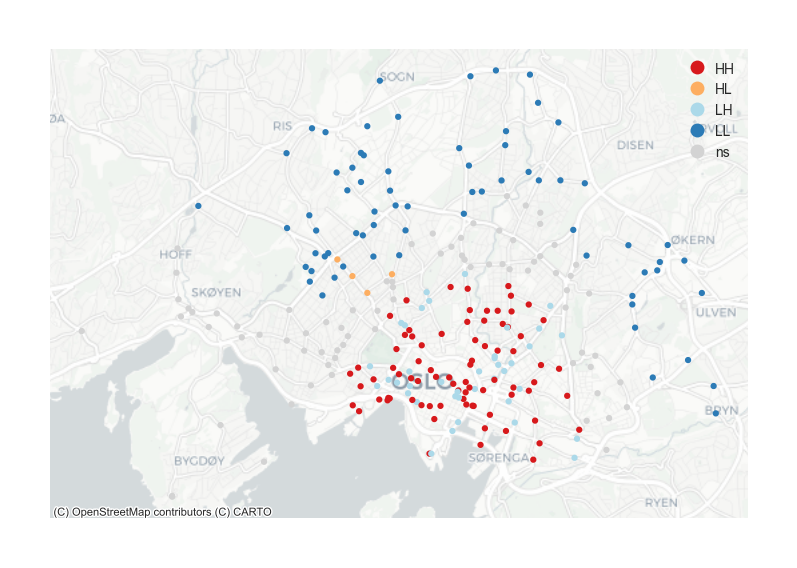

In [47]:
# Calculate local Moran's I
lisa = esda.Moran_Local(gdf_stations_cluster['num_rides_end'], w)

# Create a LISA cluster map
fig, ax = lisa_cluster(lisa, gdf_stations_cluster, p=0.05, figsize=(9, 9))

# add basemap
cx.add_basemap(
    ax,
    crs=gdf_oslo_districts.crs,
    source=cx.providers.CartoDB.Positron
)
plt.savefig(f'figures/lisa_cluster_map.png', bbox_inches='tight', pad_inches=0)

##### Lisa by start station

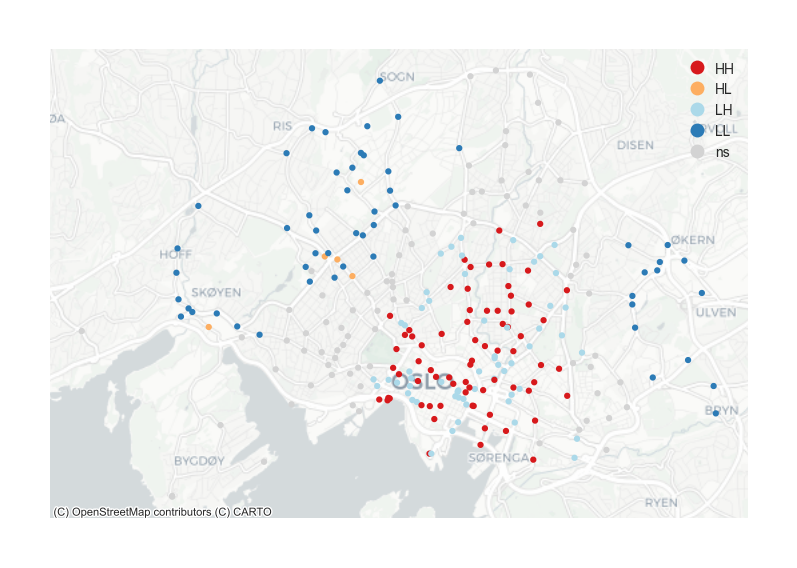

In [48]:
# Calculate local Moran's I
lisa = esda.Moran_Local(gdf_stations_cluster['num_rides_start'], w)

# Create a LISA cluster map
fig, ax = lisa_cluster(lisa, gdf_stations_cluster, p=0.05, figsize=(9, 9))

# add basemap
cx.add_basemap(
    ax,
    crs=gdf_oslo_districts.crs,
    source=cx.providers.CartoDB.Positron
)
plt.savefig(f'figures/lisa_cluster_map_start.png', bbox_inches='tight', pad_inches=0)

## Find new stations

##### Get OSM data

In [49]:
area_of_interest = 'Oslo, Norway'

# download osm data
gdf_land = ox.features_from_place(area_of_interest, tags={'landuse':True})

# Remove water geometries
gdf_land = gdf_land[gdf_land['landuse'] != 'water']

# Change the CRS of gdf_land to match that of gdf_stations
gdf_land = gdf_land.to_crs(gdf_stations.crs)

##### Find new stations to increase network density

In [52]:
n_stations = 10 # number of stations to find
n_existing_stations = gdf_stations_2024['station_id'].shape[0] # number of existing stations
n_closest_neighbours = 3 # number to calculate distance to n closest neighbours
n_stations_per_polygon = 3 # number of stations to form a polygon

# empty gdf to store new stations
new_stations = gpd.GeoDataFrame(columns=['geometry'], crs=gdf_stations.crs) 

In [53]:
gdf_stations_input = gdf_stations_2024.copy()
for i in range(n_stations):

    # create all possible combinations of n stations
    combinations_of_stations = list(combinations(gdf_stations_input.geometry, n_stations_per_polygon))

    # create polygons
    polygons = [Polygon(points) for points in tqdm(combinations_of_stations)]

    # store polygons in a new gdf
    gdf_polygons = gpd.GeoDataFrame({'geometry': polygons}, crs=gdf_stations_input.crs)

    # calculate the centroids of all polygons
    gdf_polygons['centroid'] = gdf_polygons['geometry'].centroid

    # calculate the distance from each centroid to its closest n stations
    tree = cKDTree(np.array(list(zip(gdf_stations_input.geometry.x, gdf_stations_input.geometry.y))))
    distances, indices = tree.query(np.array(list(zip(gdf_polygons['centroid'].x, gdf_polygons['centroid'].y))), n_closest_neighbours)

    # get centroid sorted by distance so that the furthest is on top
    min_distances = distances.min(axis=1)
    furthest_centroids = gdf_polygons['centroid'].loc[np.argsort(min_distances)[-n_existing_stations:]]


    # create a new GeoDataFrame for furthest_centroids
    gdf_furthest_centroids = gpd.GeoDataFrame(furthest_centroids, geometry='centroid', crs=gdf_stations_input.crs)

    # rename centroid to geometry
    gdf_furthest_centroids = gdf_furthest_centroids.rename(columns={'centroid': 'geometry'})

    for furthest_centroid in gdf_furthest_centroids['geometry']:
        print(furthest_centroid)
        # check if point is in water
        on_land = any(furthest_centroid.within(polygon) for polygon in gdf_land['geometry'])
        print("on land", on_land)
        if on_land:
            # add the new station
            gdf_stations_input = pd.concat([gdf_stations_input, gpd.GeoDataFrame({'geometry': [furthest_centroid]}, crs=gdf_stations_input.crs)])
            new_stations = pd.concat([new_stations, gpd.GeoDataFrame({'geometry': [furthest_centroid]}, crs=gdf_stations_input.crs)])
            break

    

100%|██████████| 3172316/3172316 [01:06<00:00, 47710.49it/s]


POINT (1190432.3465939406 8383807.583276246)
on land False
POINT (1190175.2709401916 8384182.492582569)
on land True


100%|██████████| 3208094/3208094 [01:08<00:00, 46842.86it/s]


POINT (1189126.1070030408 8380453.429196068)
on land True


100%|██████████| 3244140/3244140 [01:08<00:00, 47046.23it/s]


POINT (1190757.0945504992 8385843.441377373)
on land True


100%|██████████| 3280455/3280455 [01:09<00:00, 46940.44it/s]


POINT (1193489.4944135146 8378348.164129492)
on land False
POINT (1192615.4706558306 8378816.368687357)
on land False
POINT (1194296.9544796727 8378532.701808244)
on land False
POINT (1194394.2579772044 8378148.893278602)
on land False
POINT (1192705.95830893 8378729.970162142)
on land False
POINT (1192514.5112989803 8378841.217631636)
on land False
POINT (1192679.9961573163 8378757.637194981)
on land False
POINT (1194382.1221066688 8378587.86453025)
on land False
POINT (1194189.238641477 8378469.7679423755)
on land False
POINT (1192594.5229091654 8378830.320673384)
on land False
POINT (1192916.823649357 8378551.937400483)
on land False
POINT (1194394.0542886108 8378141.64747012)
on land False
POINT (1194168.3607273914 8378458.9325770615)
on land False
POINT (1192318.0122230633 8378700.972575662)
on land True


100%|██████████| 3317040/3317040 [01:11<00:00, 46607.60it/s]


POINT (1194462.475705625 8378747.675713039)
on land False
POINT (1187655.0292211464 8381526.258641524)
on land False
POINT (1194259.161999809 8378620.398075849)
on land False
POINT (1193956.280526588 8378481.605616493)
on land False
POINT (1201101.4614824827 8385537.736713164)
on land True


100%|██████████| 3353896/3353896 [01:10<00:00, 47407.51it/s]


POINT (1194082.1084357637 8378531.53690693)
on land False
POINT (1194480.400773312 8378550.314447835)
on land False
POINT (1194503.2080274543 8378671.344691939)
on land False
POINT (1193622.4667765205 8378437.4654193465)
on land False
POINT (1193605.7688529014 8378437.465419348)
on land False
POINT (1194480.6044619058 8378557.560256314)
on land False
POINT (1194408.682529903 8378737.443126063)
on land False
POINT (1194503.411716048 8378678.59050042)
on land False
POINT (1194462.475705625 8378747.675713039)
on land False
POINT (1187655.0292211464 8381526.258641524)
on land False
POINT (1194259.161999809 8378620.398075849)
on land False
POINT (1193956.280526588 8378481.605616493)
on land False
POINT (1194472.7642721054 8378527.179799673)
on land False
POINT (1194325.0910229525 8378664.395849101)
on land False
POINT (1194472.967960699 8378534.425608154)
on land False
POINT (1194420.2018147658 8378741.880961206)
on land False
POINT (1194081.9047471702 8378524.2910984475)
on land False
POIN

100%|██████████| 3391024/3391024 [01:11<00:00, 47699.37it/s]


POINT (1193594.4532566322 8378440.273392682)
on land False
POINT (1193795.4011646823 8378451.989998451)
on land False
POINT (1193695.3325472535 8378441.521090722)
on land False
POINT (1187927.2035088188 8381310.414454845)
on land False
POINT (1193939.582602969 8378481.605616492)
on land False
POINT (1194082.1084357637 8378531.53690693)
on land False
POINT (1194480.400773312 8378550.314447835)
on land False
POINT (1194503.2080274543 8378671.344691939)
on land False
POINT (1193622.4667765205 8378437.4654193465)
on land False
POINT (1193605.7688529014 8378437.465419348)
on land False
POINT (1194480.6044619058 8378557.560256314)
on land False
POINT (1194408.682529903 8378737.443126063)
on land False
POINT (1194503.411716048 8378678.59050042)
on land False
POINT (1194462.475705625 8378747.675713039)
on land False
POINT (1187655.0292211464 8381526.258641524)
on land False
POINT (1194259.161999809 8378620.398075849)
on land False
POINT (1193956.280526588 8378481.605616493)
on land False
POINT

100%|██████████| 3428425/3428425 [01:11<00:00, 48035.35it/s]


POINT (1187654.8255325528 8381519.012833044)
on land False
POINT (1192111.5366096257 8377538.606761946)
on land False
POINT (1193368.8058819312 8378161.4360755235)
on land False
POINT (1194387.9711100503 8378707.821105843)
on land False
POINT (1194324.8873343589 8378657.150040621)
on land False
POINT (1194419.9981261722 8378734.635152727)
on land False
POINT (1194481.8172300458 8378628.652529456)
on land False
POINT (1194482.0209186394 8378635.898337939)
on land False
POINT (1194093.2203434391 8378521.483125113)
on land False
POINT (1193774.3195620035 8378433.908824659)
on land False
POINT (1194092.5568458403 8378520.499213544)
on land False
POINT (1194336.406619222 8378661.587875767)
on land False
POINT (1194158.755440603 8378550.760599212)
on land False
POINT (1194387.7674214568 8378700.575297363)
on land False
POINT (1194455.9229680982 8378459.928414863)
on land False
POINT (1194456.1266566918 8378467.174223343)
on land False
POINT (1194454.8673563958 8378731.908745013)
on land Fals

100%|██████████| 3466100/3466100 [01:12<00:00, 47951.14it/s]


POINT (1194472.7642721054 8378527.179799673)
on land False
POINT (1194325.0910229525 8378664.395849101)
on land False
POINT (1194472.967960699 8378534.425608154)
on land False
POINT (1194324.4572430756 8378663.4483756395)
on land False
POINT (1194420.2018147658 8378741.880961206)
on land False
POINT (1194081.9047471702 8378524.2910984475)
on land False
POINT (1193774.523250597 8378441.154633138)
on land False
POINT (1194093.424032033 8378528.728933593)
on land False
POINT (1187654.8255325528 8381519.012833044)
on land False
POINT (1192111.5366096257 8377538.606761946)
on land False
POINT (1193368.8058819312 8378161.4360755235)
on land False
POINT (1194387.9711100503 8378707.821105843)
on land False
POINT (1194324.8873343589 8378657.150040621)
on land False
POINT (1194419.9981261722 8378734.635152727)
on land False
POINT (1194481.8172300458 8378628.652529456)
on land False
POINT (1194482.0209186394 8378635.898337939)
on land False
POINT (1194093.2203434391 8378521.483125113)
on land Fal

100%|██████████| 3504050/3504050 [01:13<00:00, 47640.15it/s]


POINT (1193605.972541495 8378444.711227829)
on land False
POINT (1194276.4320211443 8378644.238938336)
on land False
POINT (1194469.0555573637 8378755.775343642)
on land False
POINT (1193442.4216883306 8378393.530951682)
on land False
POINT (1194462.6793942184 8378754.92152152)
on land False
POINT (1193442.2179997372 8378386.2851432)
on land False
POINT (1194408.8862184966 8378744.688934541)
on land False
POINT (1194510.421530458 8378684.526996776)
on land False
POINT (1193956.484215182 8378488.851424975)
on land False
POINT (1193611.1511802513 8378440.273392683)
on land False
POINT (1194259.3656884027 8378627.643884331)
on land False
POINT (1194510.6252190513 8378691.772805257)
on land False
POINT (1193594.4532566322 8378440.273392682)
on land False
POINT (1193795.4011646823 8378451.989998451)
on land False
POINT (1193695.3325472535 8378441.521090722)
on land False
POINT (1193939.582602969 8378481.605616492)
on land False
POINT (1194082.1084357637 8378531.53690693)
on land False
POINT

In [54]:
# look at new stations
new_stations

geometry
0  POINT (1190175.271 8384182.493)
0  POINT (1189126.107 8380453.429)
0  POINT (1190757.095 8385843.441)
0  POINT (1192318.012 8378700.973)
0  POINT (1201101.461 8385537.737)
0  POINT (1195842.305 8388476.378)
0  POINT (1189408.258 8378049.462)
0  POINT (1188320.191 8379538.208)
0  POINT (1187597.004 8380506.061)
0  POINT (1202474.281 8379383.732)

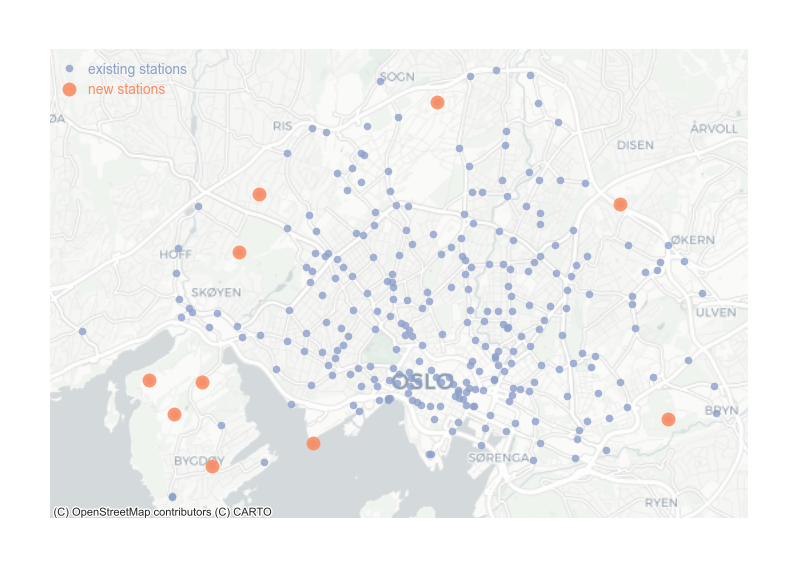

In [56]:
# plot new stations
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_stations_input.plot(alpha=0.8, ax=ax, color='#8da0cb', markersize=30, label='existing stations')
new_stations.plot(alpha=0.9, ax=ax, color='#fc8d62', markersize=100, label='new stations')


ax.set_axis_off()
plt.legend(labelcolor= ['#8da0cb','#fc8d62'],loc='upper left')
cx.add_basemap(ax, crs=gdf_stations_input.crs, source=cx.providers.CartoDB.Positron)